# ITU YZV302(3)E Deep Learning Course Fall 2024

# HW3

# Q2: Part(a) Denoising-Autoencoder (35 pts)

In this question, you will explore and learn about autoencoders. Below, you are provided with a convolution-based autoencoder designed for the MNIST dataset. Running the code will train the autoencoder and then plot the loss curve against iterations.

The code will also show two pairs of input and target images, followed by a visualization of the hidden embedding space. The current experiment uses a hidden layer size of 2 for easier visualization, but this may be prevent learning complex problems. The embedding sizes can be increased to improve the quality of reconstructions but at the expense of visualizing the entire space. However, it is possible to plot dimensions individually to observe the a distributions. Learning compressed patterns will be easier using larger hidden embedding sizes.

In this this question you will convert the autoencoder into a Denoising Autoencoder. Here, you will create some controlled corruption in the input images, while the targets remain the original images. For example, you could delete a rectangular window from the image and ask the autoencoder to reconstruct the original. Alternatively, you could add Gaussian noise and ask the autoencoder to remove the noise.

The auto-encoder does not need to work perfectly. Play with the network, hyper-parameters as you wish, to create something which seems to work.

To get full points from this question
1. **[10 pts]** Implement the input image corruption code. Explain your corruption method. What factors influenced your choice?
2. **[5 pts]** Change the training loop to work as a denoising autoencoder.
3. **[5 pts]** Tune your architecture, training, corruption, and parameters briefly. Comment on what did you change and how it affected the results.
4. **[5 pts]** Comment on the results, plot at least TWO input-output pairs of of each digit (0-9). Describe your findings.
5. **[10 pts]** The current experiment runs only on the training set. It is possible that your autoencoder memorizes specific data points and corruptions, leading to poor generalization on unseen data. Does your network memorize or generalize denoising? Write down your answer in your analysis section and perform additional experiments to support your claims.

Note: You must implement the noise/corruption yourself.

For an example of what noisy/corrupted images look like, take a look at the 'noisy.png' image.

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# plot the latent (hidden) space
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

# DataLoader is used to load the dataset
# for training


loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 32,
									shuffle = True,pin_memory=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 139363351.65it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113316832.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33599037.08it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

100%|██████████| 4542/4542 [00:00<00:00, 3459329.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Write your data corruption/noising function here. Call it from appropriate position in training.


In [5]:
# auto encoder definition

# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        act = nn.LeakyReLU(0.01)
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                act,
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(2, 2), padding=0),  # kernel size (2,2) to replace trim.
                #Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid() # perhaps you can remove this and use linear or tanh instead and scale the output back.
                )

    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x,h

In [6]:
# Model Initialization
model = AutoEncoder()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-4,
							weight_decay = 1e-5)


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter count: ", count_parameters(model))

Parameter count:  200803


In [8]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    print("epoch:", epoch)
    model.train()
    for (image, _) in loader:
        image= image.to(DEVICE)
        # Output of Autoencoder
        reconstructed, hid = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)


        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
        outputs.append((epochs, image, reconstructed))
    print('Epoch: %03d/%03d || Loss: %.4f'% (epoch+1, epochs, loss))

epoch: 0
Epoch: 001/010 || Loss: 0.0511
epoch: 1
Epoch: 002/010 || Loss: 0.0534
epoch: 2
Epoch: 003/010 || Loss: 0.0490
epoch: 3
Epoch: 004/010 || Loss: 0.0392
epoch: 4
Epoch: 005/010 || Loss: 0.0417
epoch: 5
Epoch: 006/010 || Loss: 0.0391
epoch: 6
Epoch: 007/010 || Loss: 0.0455
epoch: 7
Epoch: 008/010 || Loss: 0.0494
epoch: 8
Epoch: 009/010 || Loss: 0.0429
epoch: 9
Epoch: 010/010 || Loss: 0.0461


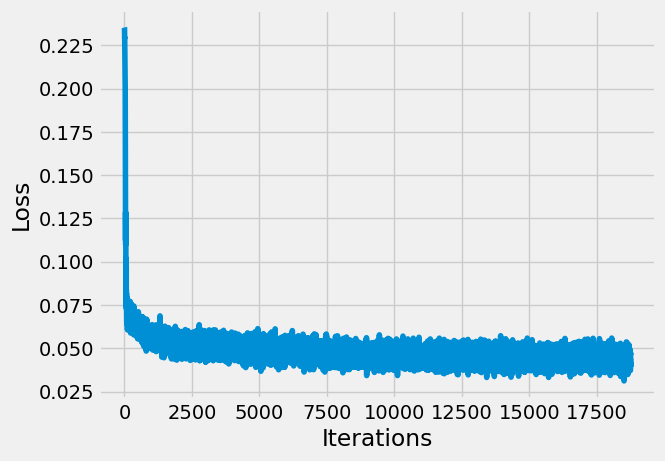

In [9]:
# plot the loss graph
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([t.detach().cpu() for t in losses])

<Figure size 640x480 with 0 Axes>

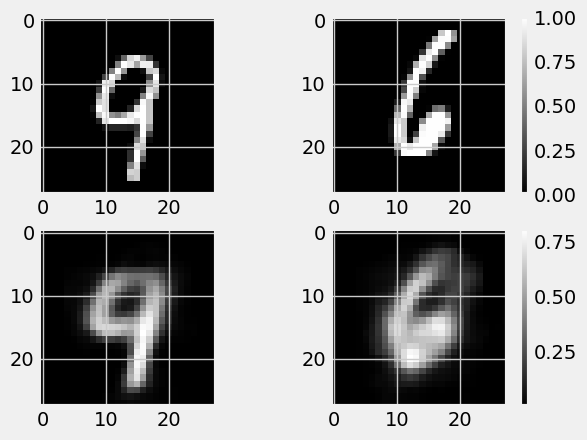

In [10]:
# plot the first two input outputs.
N = 2
plt.figure()
plt.subplots(N,2)


In [11]:
# plot the latent space if 2D
import numpy as np
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    d = {i:[] for i in range(num_classes)}

    model.eval()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = model.encoder(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

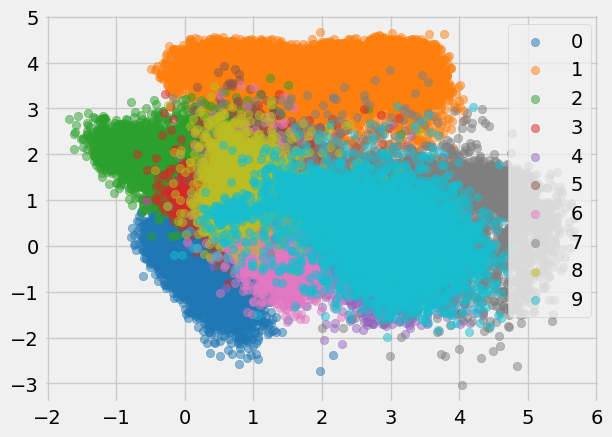

In [12]:
# call the above function to produce the graph below.

plt.legend()
plt.show()

# Add your analysis below

# Q2-Part(b) - Variational AutoEncoders VAE   [25 pts]

In this section you are required to implement Variational Autoencoder. The general structure for VAE is given below. You can use it as a template.

Variational Autoencoder is a type of autoencoder that can be used as a generative model. It has a reparametrization trick in the bottleneck to allow gradient-based optimization.

There are couple of studies you can examine before implementing the model.

Auto-Encoding Variational Bayes: 
https://arxiv.org/abs/1312.6114

Understanding Variational Autoencoders (VAEs): https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

### Load the SVHN data

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

batch_size = 64 # You can change this value depending on your GPU memory

train_data = datasets.SVHN(root = "data", split = 'train', transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 

test_data = datasets.SVHN(root = "data", split = 'test', transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

### Implement the VAE Architecture of your Design [12 pts]

Use Conv2d, ConvTranspose2d, Linear, and Activation Layers to design a Variational Autoencoder Architecture

In [ ]:
class VAE(torch.nn.Module):
    """
    Implement Variational Autoencoder for SVHN dataset
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(VAE, self).__init__()


        
    def forward(self, x):
        """
        Implement forward-pass [2 pts]
        """
        mu = None
        logvar = None
        return x, mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Implement reparameterization trick [6 pts]
        """
        out = None

        return out

    def loss_function(self, recon_x, x, mu, logvar):
        """
        Implement loss function [7 pts]
        """
        loss = None
        
        return loss

### Initialization of the Optimizer: You can change the Parameters according to your needs

In [ ]:
vae = VAE()
optimizer = None

### Implement training loop [1 pt]

In [ ]:
# train VAE

### Report the training loss curves for VAE. [1 pt]

### Show test results (generated images) for VAE. Also briefly discuss the results. [4 pts]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

### Randomly generate a sample then traverse in its latent space dimensions (add small numbers to only one dimension) see how it affects generated images. [7 pts]

#### After you have completed the training, save your model and share a google drive link for the model